# Gold Recovery Model

The purpose of any business is to make a profit.
Depending on the type of enterprise, various factors can affect profits. When it comes to the mining industry, profit is directly related to the quality of the ore and the quality of the technoly of its processing.

The goal of our project is to predict the final efficiency of concentrate enrichment in the production of gold by building and selecting the best model for forecasting.

We will build models based on data in the following csv files: '/datasets/gold_recovery_train_new.csv', '/datasets/gold_recovery_test_new.csv', '/datasets/gold_recovery_full_new.csv'.

From the task, we know that in the files the features are indicated in the following format:
 [stage].[parameter_type].[parameter_name]

Possible values for block [stage]:
 - rougher - flotation
 - primary_cleaner - primary cleaning
 - secondary_cleaner - secondary cleaning
 - final - final characteristics
Possible values for block [parameter_type]:
 - input — raw material parameters
 - output — product parameters
 - state — parameters characterizing the current state of the stage
 - calculation - calculated characteristics

Technological process:
 + Rougher feed - feedstock
 + Rougher additions (or reagent additions) - flotation reagents: Xanthate, Sulphate, Depressant
 + Xanthate — xanthate (promoter, or flotation activator);
 + Sulphate - sulfate (in this production, sodium sulfide);
 + Depressant - depressant (sodium silicate).
 + Rougher process (English "rough process") - flotation
 + Rougher tails - dump tails
 + Float banks - flotation unit
 + Cleaner process - cleaning
 + Rougher Au — rough gold concentrate
 + Final Au - final gold concentrate


Stage parameters:
 + air amount — air volume
 + fluid levels - fluid level
 + feed size - feed granule size
 + feed rate - feed rate


**The purpose of this study** is to prepare a prototype of a machine learning model for "Zifra". The company develops solutions for the efficient operation of industrial enterprises. The model should predict the recovery rate of gold from gold ore, which, in turn, will help optimize production so as not to run a plant with unprofitable characteristics. To assess the quality of the model, we will calculate **sMAPE, that is, "symmetric mean absolute percentage deviation" **, which equally takes into account the scale of both the target feature and the prediction.

**Research progress**:

We will try to build a prediction model based on data from all stages of the technological process, to do this we have to pre-process the data, train the model in the best way, check its quality through cross-validation, and then evaluate the enrichment efficiency through sMAPE. The selected model will eventually be tested on a test set.


Thus, this project will include the following steps:
* data preprocessing
* data discovery
* model building and training



## Подготовка данных



In [1]:
import numpy as np  # importing numpy
import pandas as pd  # importing pandas
import seaborn as sns # importing seaborn for plotting
import os.path as path # importing os.path for path handling
from sklearn.linear_model import LinearRegression # importing Linear Regression
from sklearn.metrics import mean_absolute_error # importing MAE
from sklearn.tree import DecisionTreeRegressor # importing Decision Tree
import warnings # importing warnings to handle warnings
warnings.simplefilter("ignore")
from sklearn.metrics  import  make_scorer # importing the metric to customize model quality measurement
import matplotlib.pyplot as plt  # importing matplotlib for plotting
from sklearn.preprocessing import StandardScaler  # importing StandardScaler to standartize features
from scipy import stats as st # importing statistic functions
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # importing GridSearchCV and RandomizedSearchCV to find find the best model
from sklearn.ensemble import RandomForestRegressor # importing Random Forest
from sklearn.dummy import DummyRegressor # importing DummyRegressor to assess the model 
from catboost import CatBoostRegressor # importing CatBoost

### Data Overview
Let's make the first idea  about the data. To view and analyze, we will read the files in csv format, save them  to variables, and also look at the first 10 objects.



In [2]:
# reading the csv file and saving to df_train
try:
    base_path = 'gold_recovery_train_new.csv' 
    df_train = pd.read_csv(base_path) if path.exists(base_path) else pd.read_csv(f'/datasets/{base_path}') # checking the path
    display(df_train.head(10))  # getting first 10 rows
except:
     print('File not found') # if no path is correct, the error message will be printed


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


Next, we will get general information about the dataset and check the quality of the data, repeating this operation for the other two datasets.



In [3]:
df_train.info() # getting general info on the dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


Thus, from the first overview of the dataset, we can conclude that it contains a significant number of features - 87. All features, except for the date and time, are quantitative, so the type of data throughout the dataset corresponds to the expected. In some features, the values are negative. Since we do not know the details of the gold production technology, we cannot consider such values to be an anomaly. At first glance, it is also clear that some features have missing values, but their number is not critical.


In [4]:
# reading the csv file and saving to df_test
try:
    base_path = 'gold_recovery_test_new.csv' 
    df_test = pd.read_csv(base_path) if path.exists(base_path) else pd.read_csv(f'/datasets/{base_path}') # checking the path
    display(df_test.head(10))  # getting first 10 rows
except:
     print('File not found') # if no path is correct, the error message will be printed


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
5,2016-09-01 05:59:59,168.485085,8.817007,7.420000,0.791191,1402.826803,-499.299521,1401.511119,-499.205357,1404.088107,...,12.029797,-499.814895,8.036586,-500.371492,8.041446,-510.037054,4.983949,-499.990990,24.978973,-500.475640
6,2016-09-01 06:59:59,144.133440,7.924610,7.420000,0.788838,1398.252401,-499.748672,1393.255503,-499.195380,1396.738566,...,12.026296,-499.473127,8.027984,-500.983079,7.907340,-507.964971,5.010224,-500.043697,25.040709,-499.501984
7,2016-09-01 07:59:59,133.513396,8.055252,6.988000,0.801871,1401.669677,-501.777839,1400.754446,-502.514024,1400.465244,...,12.040911,-501.293852,8.020490,-499.185229,8.116897,-511.927561,5.036498,-500.149615,25.032580,-503.970657
8,2016-09-01 08:59:59,133.735356,7.999618,6.935000,0.789329,1402.358981,-499.981597,1400.985954,-496.802968,1401.168584,...,11.998184,-499.481608,8.012610,-500.896783,7.974422,-521.199104,5.061599,-499.791519,25.005063,-497.613716
9,2016-09-01 09:59:59,126.961069,8.017856,7.030000,0.805298,1400.816120,-499.014158,1399.975401,-499.570552,1401.871924,...,12.040725,-499.987743,7.989503,-499.750625,7.989710,-509.946737,5.068811,-499.293900,24.992741,-499.272255


In [5]:
df_test.info() # getting general info on the dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

As for the test sample, the data type is also what we would expect for each feature. And in this dataset there is a small share of missing values. The main difference from the training dataset (except for the expectedly smaller number of objects) is that the number of features is reduced by about a third compared to the train set. We know from the assignment that some parameters are not available because they are measured and/or calculated much later. There are also no target features.


In [6]:
# reading the csv file and saving to df_full
try:
    base_path = 'gold_recovery_full_new.csv' 
    df_full = pd.read_csv(base_path) if path.exists(base_path) else pd.read_csv(f'/datasets/{base_path}') # checking the path
    display(df_full.head(10))  # getting first 10 rows
except:
     print('File not found') # if no path is correct, the error message will be printed


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


In [7]:
df_full.info() # getting general info on the dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


As for the full dataset, all 87 features are present in it, of course, there are missing values. The data type also corresponds to all the declared features.


### Checking the Enrichment Calculation Formula

In accordance with the task, we should check whether the rougher.output.recovery feature (that is, the enrichment efficiency after flotation) is calculated correctly in the training sample.

Let's make calculations manually according to the formula and compare the calculated values with those provided:



In [8]:
# defining constants for the formula
C = df_train['rougher.output.concentrate_au'] 
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

In [9]:
calculated_recovery=pd.Series(C*(F-T)/(F*(C-T))*100) # calculating recovery as per the formula
calculated_recovery.head() # checking the result

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
dtype: float64

Next, using the MAE metric, we will compare the calculations and the values of the feature in the training sample:



In [10]:
mean_absolute_error(df_train['rougher.output.recovery'], calculated_recovery) # clalculating МАЕ

9.73512347450521e-15

The obtained mean of the differences between the calculated and the dataset value for each object, taken by the modulo, is extremely small, therefore, the enrichment efficiency after flotation in the dataset is determined correctly.


### Analysis of Features in the Test Sample

Already during the overview of the data, we noticed that, compared to the training set, about a third of the features are missing in the test set (53 columns versus 87). Let's take a closer look at what features we are talking about.



In [11]:
lst = [] # creating an empty list
for col in df_train.columns: # iterating over the columns
    if col not in df_test.columns:
        lst.append(col) # appending missing columns to the list
print(lst) # checking the result

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tai

So, after having analyzed the resulting list of missing features, we can state that the test sample does not contain the results of each of the stages of processing (flotation, primary and secondary cleaning), including the final one, that is, the concentration of gold, silver and lead, as well as the substance coded as "sol" in the main product and tails. There are no data on enrichment efficiency after flotation and in the end. In addition, several calculated indicators for the flotation stage are missing both for metals and for the reagents used.
For the validation of the models that we will build to be adequate, it is necessary that the training and test sets have the same features. Therefore, we will have to remove from the former columns that are missing in the latter:


In [12]:
lst.remove('rougher.output.recovery') # removing the targte feature from the list
lst.remove('final.output.recovery') # removing the targte feature from the list

df_train_upd = df_train.drop(columns=lst) # removing the features not available in the test sample
df_train_upd.shape # checking the result

(14149, 55)

On the other hand, we have to check the results of the predictions on the test sample, therefore, it must contain both the rough concentrate enrichment efficiency (rougher.output.recovery) and the final concentrate enrichment efficiency (final.output.recovery). From the task, we know that these features for the test sample are in the general dataset, let's add them:



In [13]:
df_to_merge = df_full[['date', 'rougher.output.recovery', 'final.output.recovery']] # creating a df with only target features
df_test = df_test.merge(df_to_merge,on='date', how='left') # adding target features to the test sample
df_test.head()  # checking the result


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078


### Data Preprocessing

So, already during the data overview, we saw some shortcomings that may affect the quality of the model,
which we have to build.
First of all, let's check if there are full duplicates in the datasets:



In [14]:
for df in [df_train_upd, df_test, df_full]: # iterating over dataframes
    print(df.duplicated().sum()) # checking for full duplicates

0
0
0


So, there are no full duplicates in our dataframes, each object is unique.
Let's move on to checking for missing values, for this, for each dataframe, we calculate the proportion of objects without NaNs from the total number of objects:



In [15]:
for df in [df_train_upd, df_test, df_full]: # iterating over dataframes
    print(len(df.dropna())/len(df)) # checking for full duplicates

0.8961057318538412
0.988468809073724
0.8279232470806112


as far as we can notice that in the updated training sample, the objects with NaNs make up a little more than 10%, and in the test sample - about 1%. Since we do not have any information about the features, we are unable to fill in the missing values with any adequate value. Therefore, the best option is to remove objects containing NaN in both dataframes.
As for the general dataframe, almost 17% of the objects in it have missing values - this is a lot by generally accepted standards. We will not perform further processing of NaNs in this dataframe.



In [16]:
df_train_upd.dropna(inplace=True) # removing objects with NaNs
print(df_train_upd.shape) # checking the result

(12679, 55)


In [17]:
df_test.dropna(inplace=True) # removing objects with NaNs
print(df_test.shape) # checking the result

(5229, 55)


**Conclusions:**

So, the data has been preprocessed. We can move on to the next phase of the project: data discovery.



## Data Discovery

### Concentration of metals at different stages of enrichment

First of all, let's see how the concentration of metals (Au, Ag, Pb) changes at different cleaning stages. We can carry out this stage of analysis on the full dataset:



In [18]:
# finding the features containing the metall names
gold = []
silver = []
plumb = []
for col in df_full.columns:
    if 'au' in col:
        gold.append(col)
    elif 'ag' in col:
        silver.append(col)
    elif 'pb' in col:
        plumb.append(col)
print(gold, silver, plumb, sep='\n')


['final.output.concentrate_au', 'final.output.tail_au', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au', 'secondary_cleaner.output.tail_au']
['final.output.concentrate_ag', 'final.output.tail_ag', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.tail_ag', 'rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'rougher.output.tail_ag', 'secondary_cleaner.output.tail_ag']
['final.output.concentrate_pb', 'final.output.tail_pb', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.tail_pb', 'rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'rougher.output.tail_pb', 'secondary_cleaner.output.tail_pb']


In [19]:
# creating datasets with only selected features and cleaning from missing values:
df_au = df_full[['rougher.input.feed_au', 'rougher.output.concentrate_au', 
                 'primary_cleaner.output.concentrate_au','final.output.concentrate_au']].dropna()
df_ag = df_full[['rougher.input.feed_ag', 'rougher.output.concentrate_ag',
                 'primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']].dropna()
df_pb = df_full[['rougher.input.feed_pb', 'rougher.output.concentrate_pb',
                 'primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']].dropna()


Let's start with gold:

In [20]:
df_au.head() # checking the result


,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
0,6.486150,19.793808,34.174427,42.192020
1,6.478583,20.050975,34.118526,42.701629
2,6.362222,19.737170,33.969464,42.657501
3,6.118189,19.320810,28.260743,42.689819
4,5.663707,19.216101,33.044932,42.774141


Let's visualize gold concentration at each production stage with the help of distplot.

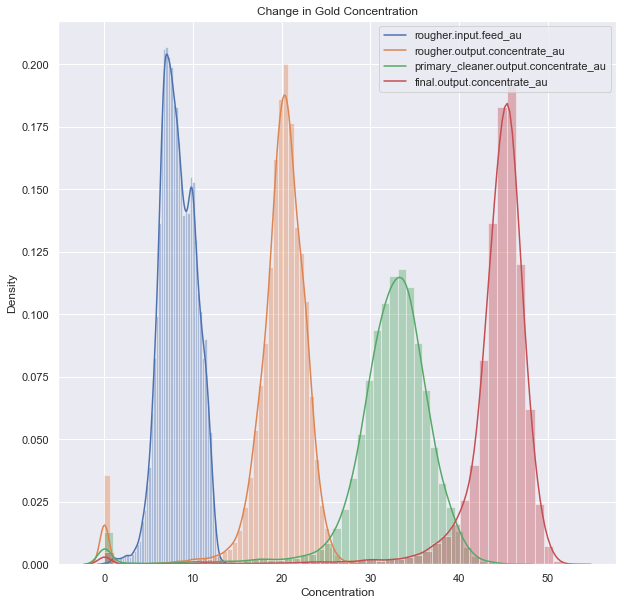

In [21]:
sns.set(rc = {'figure.figsize':(10, 10)}) # setting the size
for col in df_au.columns: # iterating over each column
    ax = sns.distplot(df_au[col]) # plotting a distplot
ax.set_xlabel("Concentration") # setting the x axis name
ax.set_title('Change in Gold Concentration') # setting the title
plt.legend(labels=df_au.columns); # visualizing the legend
    

So, we can see that, as expected, the concentration of gold increases as the cleaning proceeds. At the beginning, the peak reaches approx. 7, then rises to 20 and 35, reaching 45 after the final stage.

Let's check the dynamics of silver:



In [22]:
df_ag.head() # checking the result

,rougher.input.feed_ag,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
0,6.100378,11.500771,8.547551,6.055403
1,6.161113,11.615865,8.558743,6.029369
2,6.116455,11.695753,8.603505,6.055926
3,6.043309,11.915047,7.221879,6.047977
4,6.060915,12.411054,9.089428,6.148599


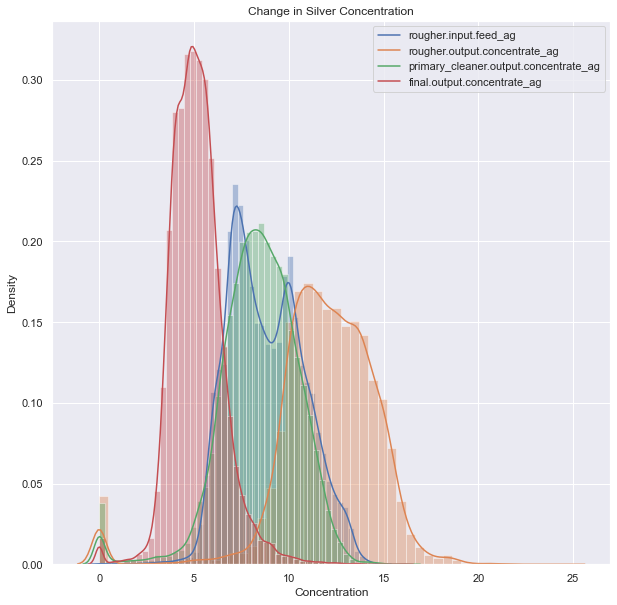

In [23]:
sns.set(rc = {'figure.figsize':(10, 10)}) # setting the size
for col in df_ag.columns: # iterating over each column
    ax = sns.distplot(df_ag[col]) # plotting a distplot
ax.set_xlabel("Concentration") # setting the x axis name
ax.set_title('Change in Silver Concentration'); # setting the title
plt.legend(labels=df_ag.columns); # visualizing the legend

As for silver, its concentration varies far from linear: it reaches its peak at the flotation stage, and takes its minimum values after the final purification.

Next, let's analyze the lead data:



In [24]:
df_pb.head() # checking the result

,rougher.input.feed_pb,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
0,2.284912,7.101074,10.389648,9.889648
1,2.266033,7.278807,10.497069,9.968944
2,2.159622,7.216833,10.354494,10.213995
3,2.037807,7.175616,8.496563,9.977019
4,1.786875,7.240205,9.986786,10.142511


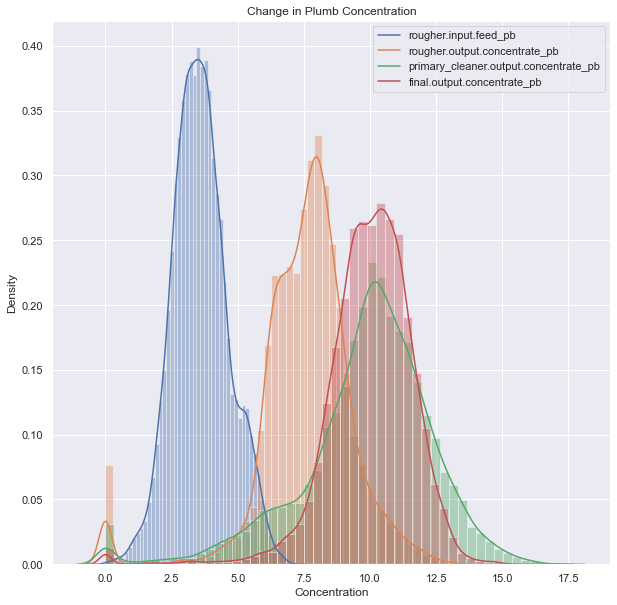

In [25]:
sns.set(rc = {'figure.figsize':(10, 10)}) # setting the size
for col in df_pb.columns: # iterating over each column
    ax = sns.distplot(df_pb[col]) # plotting a distplot
ax.set_xlabel("Concentration") # setting the x axis name
ax.set_title('Change in Plumb Concentration') # setting the title
plt.legend(labels=df_pb.columns); # visualizing the legend

As for lead, its highest concentration is reached after the first stage of cleaning, and after the final stage it drops somewhat.



### Comparison of Granule Size Distributions

Next, we will compare the distribution of granule sizes in the training and test samples. Let's plot the corresponding histograms:


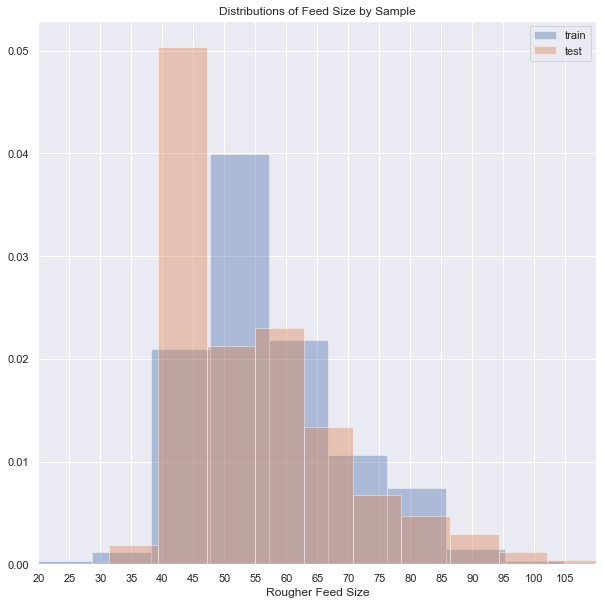

In [26]:
fig, ax = plt.subplots() # plotting 2 distplots on the same axes
sns.set(rc = {'figure.figsize':(20, 10)}) # setting the size
for a in [df_train_upd['rougher.input.feed_size'], df_test['rougher.input.feed_size']]: # for each column
    sns.distplot(a, ax=ax, kde=False, norm_hist=True) # plotting a distplot
ax.set_xlim([20, 110]) # setting min and max values on the x axis
ax.set_xticks(range(20, 110, 5))  # setting the x ticks
ax.set_xticklabels(range(20, 110, 5))  # setting the x ticks labels
ax.set_xlabel("Rougher Feed Size") # setting the x axis name
ax.set_title('Distributions of Feed Size by Sample') # setting the title
plt.legend(labels=['train', 'test']); # adding a legend


Based on the plotted distplot, we can conclude that, excluding outliers in both samples, the distributions of raw material granules differ slightly from each other.



### Calculation of Total Concentrations of Substances at Different Stages of Enrichment

So, we should analyze the concentration of substances at the following stages: in raw materials, in crude and final concentrates, that is, when fed to flotation, after flotation and after the last stage of cleaning. From the dataframe, we know that the concentration of the following substances is measured in the process: gold, silver, lead, as well as a 4th substance, coded as "sol". We will perform concentration calculations on the full dataset, adding to it the corresponding columns for each stage: before flotation, after flotation, in the final stage:


In [27]:
# creating a new summary feature at the selected production stage
df_full['input_all'] = df_full['rougher.input.feed_ag'] + df_full['rougher.input.feed_au'
                                                                 ] + df_full['rougher.input.feed_pb'
                                                                            ] + df_full['rougher.input.feed_sol']

In [28]:
# creating a new summary feature at the selected production stage
df_full['output_all'] = df_full['rougher.output.concentrate_ag'] + df_full['rougher.output.concentrate_au'
                                                                          ] + df_full['rougher.output.concentrate_pb'
                                                                                     ] + df_full['rougher.output.concentrate_sol']

In [29]:
# creating a new summary feature at the selected production stage
df_full['final_all'] = df_full['final.output.concentrate_ag'] + df_full['final.output.concentrate_au'
                                                                       ] + df_full['final.output.concentrate_pb'
                                                                                  ] + df_full['final.output.concentrate_sol']

Let's analyze the distribution of concentration during the production process using the plot:



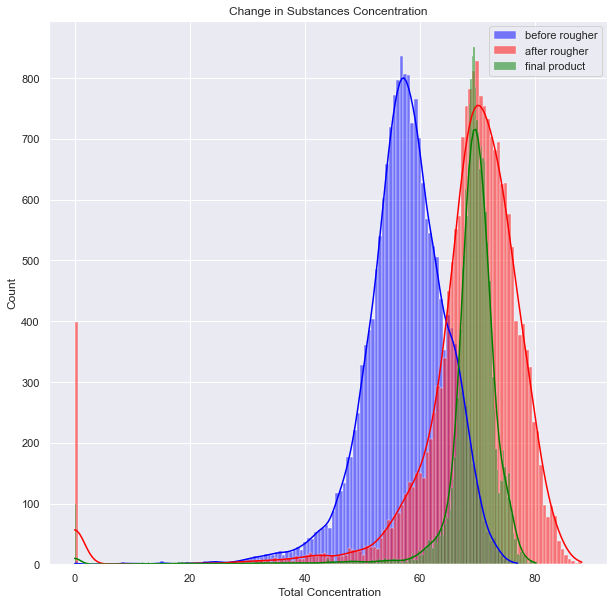

In [30]:
sns.set(rc = {'figure.figsize':(10, 10)}) # setting the size
sns.histplot(data=df_full, x="input_all", color="blue", label="before rougher", kde=True) # plotting a histogram
sns.histplot(data=df_full, x="output_all", color="red", label="after rougher", kde=True) # plotting a histogram
sns.histplot(data=df_full, x="final_all", color="green", label="final product", kde=True) # plotting a histogram
plt.xlabel(" Total Concentration") # setting the x axis name
plt.title('Change in Substances Concentration') # setting the title
plt.legend(); # visualizing the legend


According to the histograms, the maximum total concentration of the substance is reached after flotation.
In addition, based on the plot, there are outliers in the dataset, the concentration of which lies in the range from about 0 to 25. We can assume that these outliers are errors in the data.
If you look closely at the histograms, most of these values belong to the post-flotation state. At the same time, we know from the task, as well as from the plotted histograms, that after flotation, the concentration of metals at least increases or, in the worst case, remains at the same level. However, on the plot, we do not see such a huge number of observations with zero concentration in the raw material.
For this reason, these outliers can be attributed to errors and the training and test sets can be cleared of them:



In [31]:
len(df_full) # ckecking the df length before filtering

19439

In [32]:
df_full = df_full.query("input_all>0 & output_all>25 & final_all>25") # filtering off outliers

In [33]:
len(df_full) # ckecking the df length after filtering


18470

In [34]:
# setting 'date' column as index:
df_train_upd.set_index('date', inplace=True)
df_test.set_index('date', inplace=True)
df_full.set_index('date', inplace=True)

Next, taking into account the filtered full dataset, we will exclude the corresponding objects from the training and test sets:



In [35]:
df_test = df_test[df_test.index.isin(df_full.index)] # filtering off outliers
len(df_test) # checking the result


5096

In [36]:
df_train_upd = df_train_upd[df_train_upd.index.isin(df_full.index)] # filtering off outliers
len(df_train_upd) # checking the result

12181

**Conclusions**

So, we conducted a data discovery, during which we studied the concentration of different metals at different stages of enrichment and made sure that a different rule applies to each of them. As a result of the analysis of the size distribution of raw material granules, we made sure that the distributions differ slightly, and also cleared the data from outliers, therefore, we can proceed to modelling.



 ## The Models

### Preparing for sMAPE Calculation

So, according to the task, we should define a function that will calculate sMAPE, and then the final metric:



In [37]:
# defining a function for sMAPE calculation:
def smape(target, predicted):
    return  100/len(target) * np.sum(2 * np.abs(predicted - target) / (np.abs(target) + np.abs(predicted)))

In [38]:
# defining a function for final sMAPE calculation:
def overall_smape(smape_rougher, smape_final):
    return 0.25 * smape_rougher + 0.75 * smape_final
    

### Building and Fitting Models

At the previous stages of the projects, we prepared a training and test set for building prediction models.
Our task is to predict two targets at once:
1. efficiency of rough concentrate enrichment rougher.output.recovery;
2. efficiency of final concentrate final.output.recovery enrichment.

Before building models, we separate these target features into separate variables.



In [39]:
# dividing features and targets in separate variables:
features_train = df_train_upd.drop(columns=['rougher.output.recovery', 'final.output.recovery'])
target_train_rougher = df_train_upd['rougher.output.recovery']
target_train_final = df_train_upd['final.output.recovery']


In [40]:
# dividing features and targets in separate variables:
features_test = df_test.drop(columns=['rougher.output.recovery', 'final.output.recovery'])
target_test_rougher = df_test['rougher.output.recovery']
target_test_final = df_test['final.output.recovery']


We already know that some models (for example, linear regression) perform better if the features used in training are standardized. For this reason, we will standardize all quantitative features contained in the samples:



In [41]:
cols = list(features_train.columns) # creating a list with column names


In [42]:
scaler = StandardScaler() # creating StandardScaler object
scaler.fit(features_train[cols]) # fitting StandardScaler object on the train sample
features_train[cols] = scaler.transform(features_train[cols]) # stadartizing the features
features_test[cols] = scaler.transform(features_test[cols]) # stadartizing the features



So, our goal is to predict enrichment efficiency in 2 steps. There can be many answers to this question, these will be specific numbers, so our target feature is quantitative, and we are solving a regression problem.
Regression takes quantitative features as input, from this point of view, our datasets are ready, there is no need to conduct OHE or apply other similar techniques, we have already got rid of the missing values.

According to the task, we should train different models and evaluate their quality by cross-validation. To assess the quality of the models, we will use a symmetric mean absolute percentage deviation (sMAPE) calculated from two targets. The lower the deviation, the better our model will be.

#### Decision Tree

In [43]:
model = DecisionTreeRegressor(random_state=12345) # creating a model
params_grid = {'max_depth': range (1,11)}  #  setting parameters
grid_tree_r = GridSearchCV(model, params_grid, scoring=make_scorer(smape, greater_is_better=False), n_jobs=-1) # creating GridSearchCV with the parameters
grid_tree_r.fit(features_train, target_train_rougher) # fitting the model
print('The best tree sMAPE predicting flotation recovery', grid_tree_r.best_score_ ) # printing the best result
grid_tree_f = GridSearchCV(model, params_grid, scoring=make_scorer(smape, greater_is_better=False), n_jobs=-1) # creating GridSearchCV with the parameters
grid_tree_f.fit(features_train, target_train_final) #  fitting the model
print('The best tree sMAPE predicting final recovery', grid_tree_f.best_score_) # printing the best result



The best tree sMAPE predicting flotation recovery -7.766432470156596
The best tree sMAPE predicting final recovery -9.54761155317891


In [44]:
print(f'Final decision tree sMAPE is {overall_smape(grid_tree_r.best_score_, grid_tree_f.best_score_)}') # calculating final sMAPE

Final decision tree sMAPE is -9.102316782423332


#### Random Forest

In [45]:
model = RandomForestRegressor(random_state=12345) # creating a model
param_distributions = {'n_estimators': range (10, 110, 10), 'max_depth': range (1,11)}   #  setting parameters
grid_forest_r = RandomizedSearchCV(model, param_distributions, scoring=make_scorer(smape, greater_is_better=False), n_jobs=-1) # creating RandomizedSearchCV with the parameters
grid_forest_r.fit(features_train, target_train_rougher) #  fitting the model
print('the best random forest sMAPE predicting flotation recovery', grid_forest_r.best_score_ ) # printing the best result
grid_forest_f = RandomizedSearchCV(model, param_distributions, scoring=make_scorer(smape, greater_is_better=False), n_jobs=-1) # creating RandomizedSearchCV with the parameters
grid_forest_f.fit(features_train, target_train_final) #  fitting the model
print('the best random forest sMAPE predicting final recovery', grid_forest_f.best_score_) # printing the best result


the best random forest sMAPE predicting flotation recovery -7.410694042947822
the best random forest sMAPE predicting final recovery -8.889835809428588


In [46]:
print(f'Final random forest sMAPE is {overall_smape(grid_forest_r.best_score_, grid_forest_f.best_score_)}') # calculating final sMAPE

Final random forest sMAPE is -8.520050367808397


#### Linear Regression

In [47]:
model = LinearRegression()  # creating a model
params_grid = {'fit_intercept': [True, False], 'normalize': [True, False]}  #  setting parameters
grid_linear_r = GridSearchCV(model, params_grid, scoring=make_scorer(smape, greater_is_better=False), n_jobs=-1) # creating GridSearchCV with the parameters
grid_linear_r.fit(features_train, target_train_rougher) #  fitting the model
print('the best linear regression sMAPE predicting flotation recovery', grid_linear_r.best_score_ ) # printing the best result
grid_linear_f = GridSearchCV(model, params_grid, scoring=make_scorer(smape, greater_is_better=False), n_jobs=-1) # creating GridSearchCV with the parameters
grid_linear_f.fit(features_train, target_train_final) #  fitting the model
print('the best linear regression sMAPE predicting final recovery', grid_linear_f.best_score_) # printing the best result


the best linear regression sMAPE predicting flotation recovery -9.170517145785013
the best linear regression sMAPE predicting final recovery -11.538811815623276


In [48]:
print(f'Final linear regression sMAPE is{overall_smape(grid_linear_r.best_score_, grid_linear_f.best_score_)}') # calculating final sMAPE

Final linear regression sMAPE is-10.94673814816371


#### Catboost

In [53]:
model = CatBoostRegressor(random_seed=12345) # creating a model
param_distributions = {'iterations': range (10, 110, 10), 'max_depth': range (1,11)}   #  setting parameters
clf_r = RandomizedSearchCV(model, param_distributions, scoring=make_scorer(smape, greater_is_better=False), n_jobs=-1) # creating RandomizedSearchCV with the parameters
clf_r.fit(features_train, target_train_rougher) #  fitting the model
print('the best Catboost sMAPE predicting flotation recovery', clf_r.best_score_ ) # printing the best result
clf_f = RandomizedSearchCV(model, param_distributions, scoring=make_scorer(smape, greater_is_better=False), n_jobs=-1) # creating RandomizedSearchCV with the parameters
clf_f.fit(features_train, target_train_final) #  fitting the model
print('the best Catboost sMAPE predicting final recovery', clf_f.best_score_) # printing the best result


Learning rate set to 0.5
0:	learn: 6.4708481	total: 6.52ms	remaining: 58.7ms
1:	learn: 5.9338030	total: 11.6ms	remaining: 46.2ms
2:	learn: 5.5082410	total: 17.3ms	remaining: 40.3ms
3:	learn: 5.3070570	total: 22.6ms	remaining: 33.9ms
4:	learn: 5.1828065	total: 28.5ms	remaining: 28.5ms
5:	learn: 5.0994193	total: 33.8ms	remaining: 22.5ms
6:	learn: 5.0425052	total: 38.8ms	remaining: 16.6ms
7:	learn: 4.9811961	total: 44ms	remaining: 11ms
8:	learn: 4.9319580	total: 48.5ms	remaining: 5.39ms
9:	learn: 4.8792418	total: 52.6ms	remaining: 0us
the best Catboost sMAPE predicting flotation recovery -7.288983151122595
Learning rate set to 0.5
0:	learn: 7.6415739	total: 4.22ms	remaining: 80.2ms
1:	learn: 7.2909370	total: 7.96ms	remaining: 71.7ms
2:	learn: 7.0924648	total: 11.8ms	remaining: 66.7ms
3:	learn: 6.9267344	total: 15.3ms	remaining: 61.3ms
4:	learn: 6.8354277	total: 20.1ms	remaining: 60.3ms
5:	learn: 6.7557133	total: 23.4ms	remaining: 54.5ms
6:	learn: 6.7003729	total: 27ms	remaining: 50.2ms
7:

In [54]:
print(f'Final Catboost sMAPE is {overall_smape(clf_r.best_score_, clf_f.best_score_)}') # calculating final sMAPE

Final Catboost sMAPE is -9.36245620512902


**Conclusions**

So, according to the results of cross-validation of models, the best result, that is, the lowest value of sMAPE, was shown by the Catboost model. Next, we check the quality of predictions on the test set:



### Checking the Selected Model on the Test Sample



In [55]:
pred_test_rougher = clf_r.predict(features_test) # predicting flotation recovery

In [56]:
pred_test_final = clf_f.predict(features_test) # predicting final recovery

In [57]:
overall_smape(smape(target_test_rougher, pred_test_rougher), smape(target_test_final, pred_test_final)) # calculating final sMAPE

6.424730686297146

So, on the test sample, the value of sMAPE is comparable and even somewhat less than on the training one. The model has been successfully tested.
Next, we check the model for adequacy, for this we compare it with a constant model:


In [58]:
dummy_regr_r = DummyRegressor(strategy="median") # creating a constant model
dummy_regr_r.fit(features_train, target_train_rougher) # fitting the model
dummy_pred_r = dummy_regr_r.predict(features_test) # predicting flotation recovery

In [59]:
dummy_regr_f = DummyRegressor(strategy="median") # creating a constant model
dummy_regr_f.fit(features_train, target_train_final) # fitting the model
dummy_pred_f = dummy_regr_r.predict(features_test) # predicting final recovery

In [60]:
overall_smape(smape(target_test_rougher, dummy_pred_r), smape(target_test_final, dummy_pred_f)) # calculating final sMAPE

17.57447507450438

So, the constant model showed a different, and most importantly, the worst result compared to a catboost. Therefore, the model is adequate and can go into production.



## Study Results 
In the course of the study, we processed and analyzed the data, as a result of which we managed to find out some details of the technology, get rid of missing values and outliers, standardize features in order to  subsequently develop, fit 3 regression models.
We checked the results of model fitting by cross-validation, choosing the optimal hyperparameters.
According to the results of the comparison, it turned out that the most **qualitatively (with the minimum sMAPE value) gold enrichment efficiency is predicted by the catboost  model.**
When testing the model **on test sample, it showed even better results.**

Perhaps the result would be even better if we applied alternative regression models not yet known to us.
